In [52]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [53]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the Alpaca api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [54]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [97]:
tickers = ["SPY", "AGG"]
timeframe = '1D'
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()
start_date = pd.Timestamp('2019-01-01', tz = 'America/New_York').isoformat()
df = api.get_barset(
    tickers,
    timeframe, 
    limit=None,
    start = start_date,
    end = end_date, 
    after = None, 
    until = None, 
).df

df.head(2)

AGG                                          \
                             open     high       low    close      volume   
2019-01-02 00:00:00-05:00  106.55  106.610  106.4701  106.585  10164756.0   
2019-01-03 00:00:00-05:00  106.57  107.075  106.5700  107.020   6260265.0   

                              SPY                                     
                             open    high     low   close     volume  
2019-01-02 00:00:00-05:00  245.98  251.21  245.95  249.89  107236613  
2019-01-03 00:00:00-05:00  248.23  248.57  244.03  244.46  113782919

In [98]:
df.drop(columns = ['open', 'high', 'low', 'volume'], level =1, inplace=True)
df.head()

,AGG,SPY
,close,close
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [99]:
# Calculate the daily roi for the stocks
# YOUR CODE HERE
daily_returns = df.pct_change()
daily_returns.head()

,AGG,SPY
,close,close
2019-01-02 00:00:00-05:00,NaN,NaN
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844


In [100]:
spy_avg_daily_return = daily_returns.mean()['SPY']['close']
agg_avg_daily_return = daily_returns.mean()['AGG']['close']

In [101]:
# Calculate volatility
# YOUR CODE HERE
spy_std_df = daily_returns.std()['SPY']['close']
agg_std_df = daily_returns.std()['AGG']['close']
print(f"AGG std: {agg_std_df}, SPY std: {spy_std_df}")

AGG std: 0.0020886019741764646, SPY std: 0.007820053413439366


In [102]:
# Save the last day's closing price
# YOUR CODE HERE
spy_close = df['SPY']['close'][-1]
agg_close = df['AGG']['close'][-1]

In [103]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [104]:
# Run the Monte Carlo Simulation
for n in range(number_simulations):
    
    spy_simulated_prices = [spy_close]
    agg_simulated_prices = [agg_close]
    
    for i in range(number_records):
        spy_simulated_price = spy_simulated_prices[-1]*(1+np.random.normal(spy_avg_daily_return, spy_std_df))
        agg_simulated_price = agg_simulated_prices[-1]*(1+np.random.normal(agg_avg_daily_return, agg_std_df))
        
        spy_simulated_prices.append(spy_simulated_price)
        agg_simulated_prices.append(agg_simulated_price)
    simulated_price_df['SPY prices'] = pd.Series(spy_simulated_prices)
    simulated_price_df['AGG prices'] = pd.Series(agg_simulated_prices)
    
    simulated_daily_returns = simulated_price_df.pct_change()
    
    weights = [0.6, 0.4]
    
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    portfolio_cumulative_returns[n] = (1+portfolio_daily_returns.fillna(0)).cumprod()
    
    
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001184,0.990077,1.001324,0.996946,1.000175,0.991821,0.992977,1.011102,0.993890,1.009255,...,1.004504,1.004251,0.996949,0.998873,1.008162,0.998099,1.001406,0.996561,0.999123,0.995506
2,1.001816,0.985995,1.003821,0.990171,0.999496,0.991852,0.997732,1.009544,0.991250,1.010639,...,1.004820,0.998770,0.999254,0.994957,1.018098,0.999461,0.993696,0.998222,0.999117,0.999713
3,0.999107,0.973259,0.999690,0.993035,0.996465,0.991386,1.002450,1.008059,0.985202,1.009902,...,1.005453,1.005773,0.996690,0.996821,1.023552,1.007192,0.999018,1.000280,1.007527,1.001172
4,0.995950,0.975914,1.004349,0.989873,1.000477,0.982230,1.003849,1.010109,0.976204,1.015760,...,1.008747,1.018063,1.002949,0.992218,1.026762,1.007074,0.996149,1.001942,1.005149,1.000953


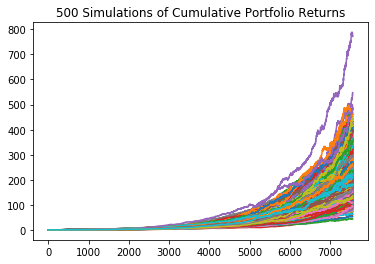

In [105]:
# Visualize the Simulation
# YOUR CODE HERE
plot_title = f"{n+1} Simulations of Cumulative Portfolio Returns"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [106]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
# YOUR CODE HERE
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1,:]
ending_cumulative_returns.head()

0    224.609250
1    367.670918
2     89.769532
3    250.714801
4    312.501829
Name: 7560, dtype: float64

In [107]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# YOUR CODE HERE
cumulative_returns_20 = portfolio_cumulative_returns.iloc[-2520, :]
cumulative_returns_20.head()

0    36.192339
1    49.523444
2    20.177673
3    38.303049
4    30.316711
Name: 5041, dtype: float64

In [108]:
ending_cumulative_returns.value_counts(bins=10)/len(ending_cumulative_returns)

(117.627, 190.296]               0.408
(190.296, 262.965]               0.230
(262.965, 335.634]               0.148
(44.230000000000004, 117.627]    0.106
(335.634, 408.303]               0.068
(408.303, 480.972]               0.030
(480.972, 553.641]               0.008
(698.979, 771.648]               0.002
(626.31, 698.979]                0.000
(553.641, 626.31]                0.000
Name: 7560, dtype: float64

In [109]:
# Display the 90% confidence interval for the ending returns
# YOUR CODE HERE
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval


0.05     99.929405
0.95    399.798339
Name: 7560, dtype: float64

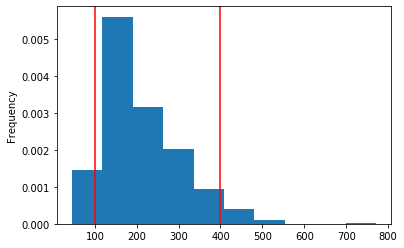

In [110]:
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r') 

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [112]:
# YOUR CODE HERE
expected_returns = ending_cumulative_returns.quantile(q=[0.1, 0.5, 0.9])
expected_returns

0.1    117.172797
0.5    188.417280
0.9    337.970017
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [121]:
# YOUR CODE HERE
initial_investment = 20000

return_10 = initial_investment + (initial_investment*expected_returns.iloc[0])
return_50 = initial_investment + (initial_investment*expected_returns.iloc[1])
return_90 = initial_investment + (initial_investment*expected_returns.iloc[2])

print(f"Expected return at 10: {return_10}, Expected return at 50: {return_50}, Expected return at 90: {return_90}")


Expected return at 10: 2363455.937029667, Expected return at 50: 3788345.595658193, Expected return at 90: 6779400.334138952


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [123]:
# YOUR CODE HERE
income = 7389

retirement_income = .04 * (initial_investment * expected_returns.iloc[0])

print(retirement_income)

93738.23748118669


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [128]:
# YOUR CODE HERE
new_initial = initial_investment * 1.5
retirement_plus = .04 * (new_initial * expected_returns.iloc[0])
retirement_plus

140607.35622178004

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [139]:
# YOUR CODE HERE
challenge_returns = portfolio_cumulative_returns.quantile(q=[0.05, 0.5, 0.95], axis=1, numeric_only=True).T
challenge_returns


,0.05,0.50,0.95
0,1.000000,1.000000,1.000000
1,0.992698,1.000871,1.008614
2,0.990515,1.001285,1.012738
3,0.988439,1.002381,1.015519
4,0.987052,1.002669,1.020064
...,...,...,...
7556,98.532195,188.025345,398.553948
7557,98.561708,187.986492,398.766174
7558,98.795688,188.196939,398.130310
7559,99.623382,188.419686,398.228194


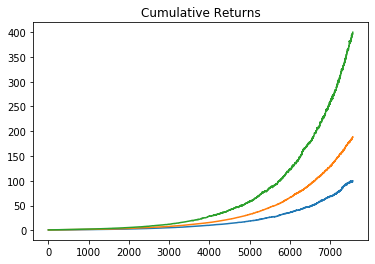

In [140]:
challenge_returns.plot(title="Cumulative Returns", legend = None)